In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import seaborn as sns
import emm
import warnings
warnings.filterwarnings('ignore')

# Plot styles
plt.style.use('seaborn-notebook')

import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
processed_dir = "../assets/data/processed/pima_diabetes/"
# Get data into dataframe
df = pd.read_csv(processed_dir + "diabetes.csv",index_col=0)

# Replace 0 with nan
nan_cols = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']
df[nan_cols]=df[nan_cols].replace({'0':np.nan,0:np.nan})

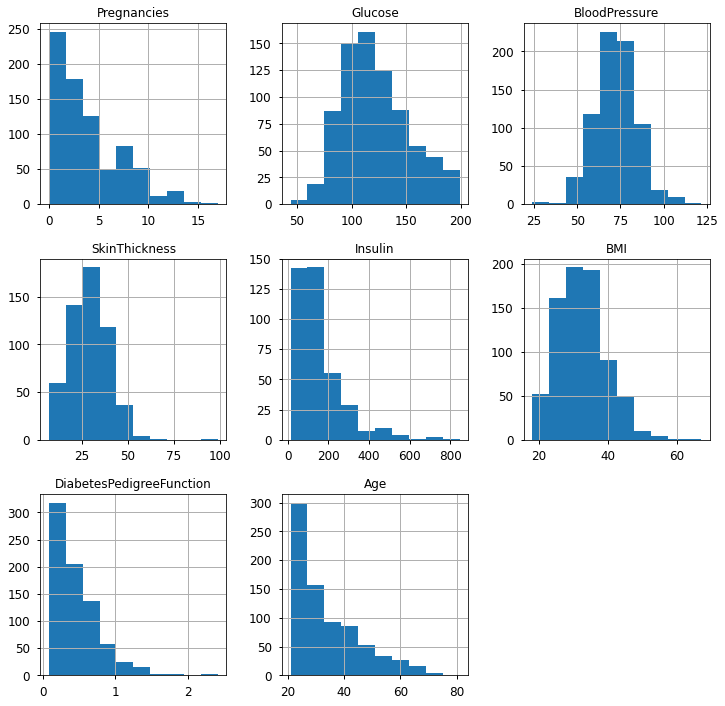

In [3]:
df.drop(columns='Outcome').hist(figsize=(12,12))
plt.show()

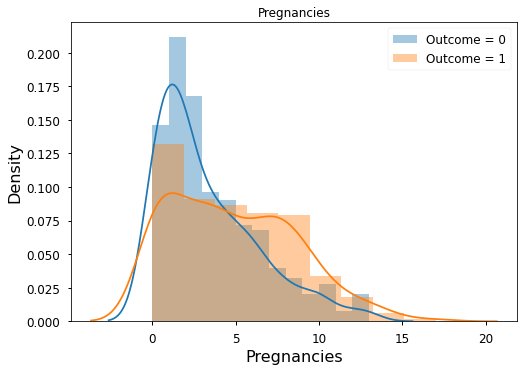

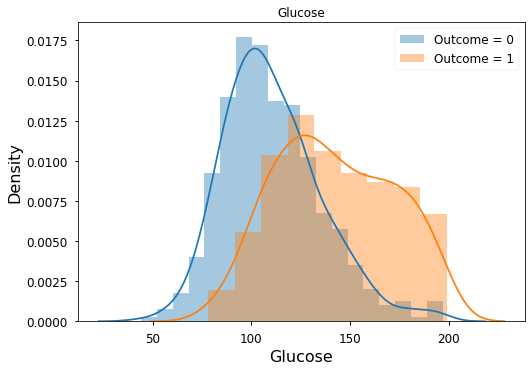

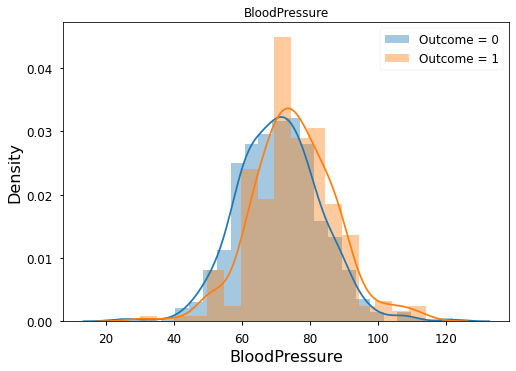

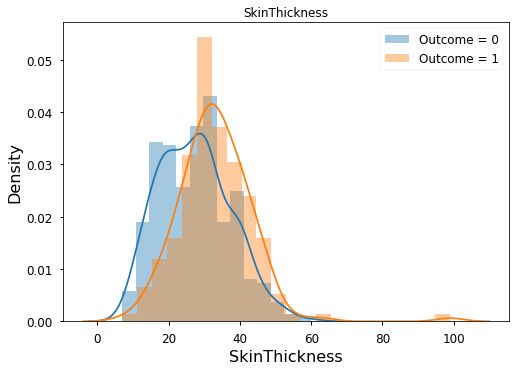

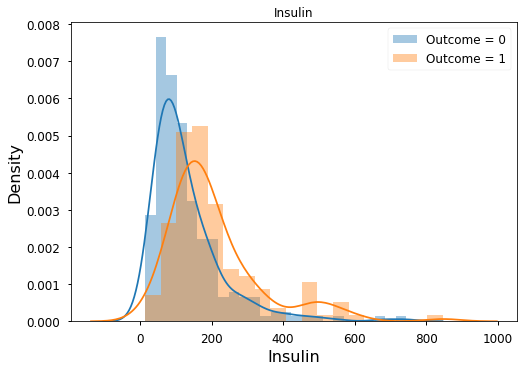

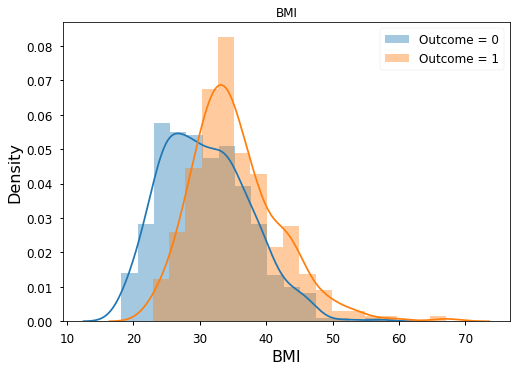

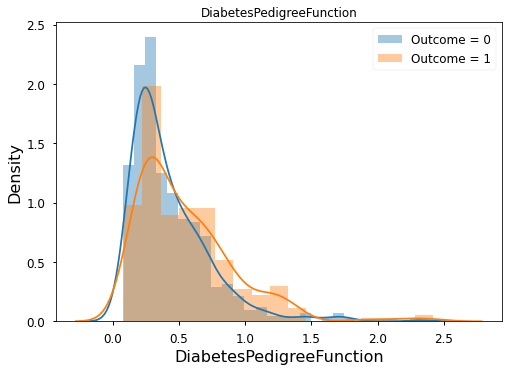

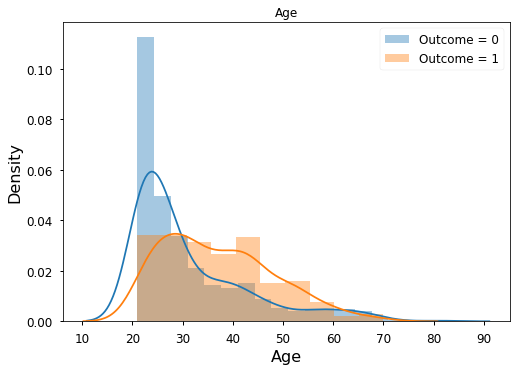

In [4]:
for cols in df.drop(columns='Outcome'):
    d1 = df[df['Outcome']==0][cols]
    d2 = df[df['Outcome']==1][cols]
    sns.distplot(d1, label='Outcome = 0',)
    sns.distplot(d2, label='Outcome = 1')
    plt.legend()
    plt.title(cols)
    plt.show()

In [5]:
marginals_mean = df.groupby('Outcome').mean()
m_0 = marginals_mean.loc[0]
m_1 = marginals_mean.loc[1]
display(marginals_mean)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,110.643863,70.877339,27.235457,130.287879,30.859674,0.429734,31.190000
1,4.865672,142.319549,75.321429,33.000000,206.846154,35.406767,0.550500,37.067164


In [6]:
df.isnull().sum(axis = 0)

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [121]:
from emm.losses import LeastSquaresLoss
lam = 0
margs = {0 : {'Glucose' : {'fun' : ['mean'],
                           'loss': [LeastSquaresLoss(m_0['Glucose'])]},
              'BloodPressure' : {'fun' : ['mean'],
                                 'loss': [LeastSquaresLoss(m_0['BloodPressure'])]},
              'regularizer' : {'reg' : emm.regularizers.EntropyRegularizer(),
                                  'lam' : lam}},
         1 : {'Glucose' : {'fun' : ['mean'],
                           'loss': [LeastSquaresLoss(m_1['Glucose'])]},
              'BloodPressure' : {'fun' : ['mean'],
                                 'loss': [LeastSquaresLoss(m_1['BloodPressure'])]},
              'regularizer' : {'reg' : emm.regularizers.EntropyRegularizer(),
                                  'lam' : lam}}}
            

margs = [margs]
target = df
corpus = df.drop(columns = 'Outcome')
from sklearn.linear_model import LogisticRegression
param_grid_log =  {"classifier" : [LogisticRegression()],
                 "classifier__C": np.logspace(-3,3,7), 
                   "classifier__penalty":["l2"]}
from sklearn.tree import DecisionTreeClassifier
param_grid_tree =  {'classifier' : [DecisionTreeClassifier()],
     'classifier__max_depth' : [2,4,6,7,9]}
param_grid = [param_grid_log, param_grid_tree]
   
(rw_corpus, js, ml) = emm.metrics.multiple_models(target,corpus,margs, 
                                        param_grid, verbose=True, scoring='f1')

CVX took 0.05066 seconds
CVX took 0.04565 seconds
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Target data: the best parameters are given by 
 LogisticRegression(C=100.0)
 the best mean cross-validation accuracy 64.98973 +/- 5.92291% on training dataset 

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Target data: the best parameters are given by 
 DecisionTreeClassifier(max_depth=7)
 the best mean cross-validation accuracy 62.68501 +/- 3.52409% on training dataset 



In [122]:
ml

[{'accuracy_score': {'RR': 0.7792207792207793,
   'RS': 0.6311166060097452,
   'SS': 0.6430251189946696,
   'SR': 0.7597402597402597}},
 {'accuracy_score': {'RR': 0.7662337662337663,
   'RS': 0.6317036560364546,
   'SS': 0.44589718016454666,
   'SR': 0.7012987012987013}}]

In [123]:
rw_corpus.drop(columns = ['weights' , 'Outcome']).T @ rw_corpus['weights']

Pregnancies                  3.851240
Glucose                           NaN
BloodPressure                     NaN
SkinThickness                     NaN
Insulin                           NaN
BMI                               NaN
DiabetesPedigreeFunction     0.488276
Age                         33.753408
dtype: float64

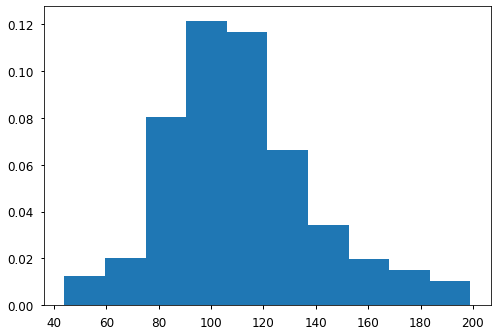

In [131]:
plt.hist(rw_corpus[rw_corpus['Outcome']==0]['Glucose'], 
         weights=rw_corpus[rw_corpus['Outcome']==0]['weights'], bins=10)
plt.show()

In [126]:
js

[0.045624901606166605]

In [127]:
rw_corpus['weights'][rw_corpus['weights'] < 0] = 0

In [128]:
rw_corpus['weights'].shape

(1536,)

In [129]:
rw_corpus['BloodPressure'].shape

(1536,)

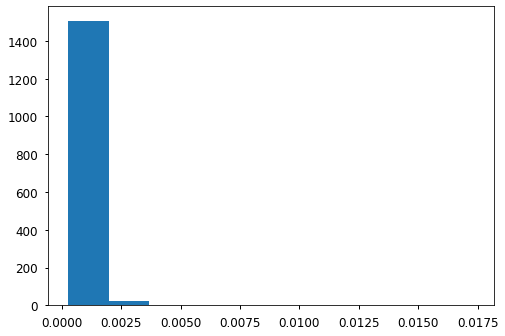

In [130]:
plt.hist(rw_corpus['weights'])
plt.show()